## Gagan Chordia - 19BCE0788

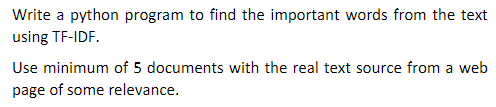

In [1]:
#importing important libraries
import nltk, os, string, numpy as np, copy, pandas as pd, pickle, re, math

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from num2words import num2words

In [2]:
title = "stories"
alpha = 0.3

In [3]:
#reading folders
folder = [x[0] for x in os.walk(str(os.getcwd()) + '/' + title + '/')]
folder[0] = folder[0][:len(folder[0]) - 1]
folder

['E:\\Material\\WebMining/stories',
 'E:\\Material\\WebMining/stories/FARNON',
 'E:\\Material\\WebMining/stories/SRE']

In [4]:
#collecting file names to prepare data
dataset = []
flag = False

for i in folder:
    file = open(i + '/index.html', 'r')
    text = file.read().strip()
    file.close()
    
    file_name = re.findall('><A HREF="(.*)"', text)
    file_title = re.findall('<BR><TD>(.*)\n', text)
    
    if not flag:
        file_name = file_name[2:]
        flag = True
    
    for j in range(len(file_name)):
        dataset.append((str(i) + "/" + str(file_name[j]), file_title[j]))
        
n = len(dataset)
print(n)

467


In [5]:
#defining custom functions for pre-processing
def print_doc(id):
    print(dataset[id])
    file = open(dataset[id][0], 'r', encoding = 'cp1250')
    text = file.read().strip()
    file.close()
    print(text)
    
def convert_lower_case(data):
    return np.char.lower(data)

def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text

def rem_punctuations(data):
    symbols = "!@#$%^&*()\"*+-/:;<=>?[\]_`{|}~,\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], '')
        data = np.char.replace(data, "  ", '')
    data = np.char.replace(data, "'", '')
    return data

def stemmer(data):
    stem = PorterStemmer()
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stem.stem(w)
        
    return new_text

def num_to_words(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    
    for w in tokens:
        try:
            w = num2words(w)
        except:
            pass
        new_text = new_text + " " + w
        
    return new_text

def preprocessing(data):
    data = num_to_words(data)
    data = convert_lower_case(data)
    data = remove_stop_words(data)
    data = rem_punctuations(data)
    data = stemmer(data)
    
    return data

In [6]:
#data extraction
processed_text = []
processed_title = []

for i in dataset[:n]:
    try:
        file = open(i[0], 'r', errors = "ignore", encoding="utf8")
        text = file.read().strip()
        file.close()
    except:
        pass
    
    processed_text.append(word_tokenize(str(preprocessing(text))))
    processed_title.append(word_tokenize(str(preprocessing(i[1]))))

In [7]:
#calculating DF
df = {}

for i in range(n):
    tokens = processed_text[i]
    for w in tokens:
        try:
            df[w].add(i)
            
        except:
            df[w] = {i}
    tokens = processed_title[i]
    for w in tokens:
        try:
            df[w].add(i)
            
        except:
            df[w] = {i}
for i in df:
    df[i] = len(df[i])

In [8]:
total_vocab_size = len(df)
total_vocab = [x for x in df]

In [9]:
def doc_freq(word):
    x = 0
    try:
        x = df[word]
    except:
        pass
    return x

In [10]:
#calculating tf-idf for body
doc = 0
tf_idf = {}
for i in range (n):
    tokens = processed_text[i]
    counter = Counter(tokens + processed_title[i])
    words_count = len(tokens + processed_title[i])
    
    for token in np.unique(tokens):
        tf = counter[token]/words_count
        df = doc_freq(token)
        idf = np.log((n + 1) / (df + 1))
        
        tf_idf[doc, token] = tf*idf
    doc += 1

In [11]:
#calculating tf-idf for title
doc = 0
tf_idf_title = {}
for i in range (n):
    tokens = processed_title[i]
    counter = Counter(tokens + processed_text[i])
    words_count = len(tokens + processed_text[i])
    
    for token in np.unique(tokens):
        tf = counter[token]/words_count
        df = doc_freq(token)
        idf = np.log((n + 1) / (df + 1))
        
        tf_idf_title[doc, token] = tf*idf
    doc += 1

In [12]:
#merging tf-idf according to weights
for i in tf_idf:
    tf_idf[i] *= alpha
    
for i in tf_idf_title:
    tf_idf[i] = tf_idf_title[i]
    
len(tf_idf)

372400

In [13]:
#matching score
def matching_score(k, query):
    preprocessed_query = preprocessing(query)
    tokens = word_tokenize(str(preprocessed_query))
    
    print('Matching Scores')
    print('Query: ', query)
    print('\n', tokens)
    
    query_weights = {}
    
    for key in tf_idf:
        if key[1] in tokens:
            try:
                query_weights[key[0]] += tf_idf[key]
            except:
                query_weights[key[0]] = tf_idf[key]
    
    query_weights = sorted(query_weights.items(), key = lambda x: x[1], reverse = True)
    
    l = []
    for i in query_weights[:k]:
        l.append(i[0])
        
    print("\n", l)
matching_score(10, "Without the drive of Rebbecah's insistence, Kate lost her momentum. She stood next to a slatted oak bench, cannisters still clutched, surveying.")

Matching Scores
Query:  Without the drive of Rebbecah's insistence, Kate lost her momentum. She stood next to a slatted oak bench, cannisters still clutched, surveying.

 ['without', 'drive', 'rebbecah', 's', 'insist', 'kate', 'lost', 'momentum', 'stood', 'next', 'slat', 'oak', 'bench', 'cannist', 'still', 'clutch', 'survey']

 [32, 166, 432, 371, 433, 352, 316, 258, 192, 259]


In [14]:
#cosine similarity
def cos_prod(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [15]:
temp = np.zeros((n, total_vocab_size))

for i in tf_idf:
    try:
        ind = total_vocab.index(i[1])
        temp[i[0]][ind] = tf_idf[i]
    except:
        pass

In [16]:
def gen_vector(tokens):
    temp = np.zeros((len(total_vocab)))
    
    counter = Counter(tokens)
    words_count = len(tokens)
    query_weights = {}
    
    for i in np.unique(tokens):
        tf = counter[i] / words_count
        df = doc_freq(tokens)
        idf = math.log((n + 1) / (df + 1))
        
        try:
            ind = total_vocab.index(i)
            temp[ind] = tf * idf
        except:
            pass
    return temp

In [17]:
def cos_similarity(k, query):
    preprocessed_query = preprocessing(query)
    tokens = word_tokenize(str(preprocessed_query))
    
    print('Cosine Similarity')
    print('Query: ', query)
    print('\n', tokens)
    
    cosines = []
    query_vec = gen_vector(tokens)
    
    for i in temp:
        cosines.append(cos_prod(query_vec, i))
        
    result = np.array(cosines).argsort()[-k:][::-1]
    print("\n", result)
    
cos_similarity(10, "Without the drive of Rebbecah's insistence, Kate lost her momentum. She stood next to a slatted oak bench, cannisters still clutched, surveying.")

Cosine Similarity
Query:  Without the drive of Rebbecah's insistence, Kate lost her momentum. She stood next to a slatted oak bench, cannisters still clutched, surveying.

 ['without', 'drive', 'rebbecah', 's', 'insist', 'kate', 'lost', 'momentum', 'stood', 'next', 'slat', 'oak', 'bench', 'cannist', 'still', 'clutch', 'survey']

 [433 371 395 192  95 200  48 265 260  65]


In [18]:
print_doc(200)

('E:\\Material\\WebMining/stories/ghost', ' Time for Flowers, by Gay Bost')
TIME FOR FLOWERS
  by Gay Bost

They'd put flowers up. She hadn't noticed. Time wouldn't hold still.
She remembered, quite clearly, that time had been a simple thing; one
moment following the previous one, seconds strung out neatly like her
mother's pearls laid out on the dark mahogany vanity each Sunday
morning. But there had been a catch . . . 

Hung around Mother's neck the catch clicked and the tidy little line 
of seconds became a never ending circle with only the catch in the 
middle. For some reason the thought of pearls gathered from the sea, 
naturally nested within the confines of oyster shells, scattered 
haphazardly about the ocean floor disturbed her.

Now they'd put up the flowers in the same careless groupings. This,
too, disturbed her. Bright yellow trumpets, their collars spread to
catch the sun, dotted the front yard in clusters of two or three, five
or six. Bunches laid carelessly and forgott